In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

# We also set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
np.random.seed(1234)
_ = torch.manual_seed(123)

## dataset : OMOP-CDM 

In [10]:
import os
import pathlib
current_dir = pathlib.Path.cwd()
parent_dir = current_dir.parent
data_dir = pathlib.Path('{}/CDM'.format(current_dir))
output_dir = pathlib.Path('{}/output'.format(current_dir))
#pathlib.Path.mkdir(output_dir, mode=0o777, exist_ok=True)
#print(current_dir)

file_list = os.listdir(data_dir)
file_list = [pathlib.Path(filename).with_suffix('').name for filename in file_list]

In [11]:
import pandas as pd

concat_df = pd.read_csv('{}/{}.txt'.format(data_dir, file_list[0]), index_col=False)

def timeSeriesToTimeData(timeseries_df):
    ts_df = timeseries_df.sort_values(['subject_id', 'concept_date'], ascending=[True, True])
    td_df = ts_df.groupby('subject_id', as_index=False).max()
    return td_df

concat_df = timeSeriesToTimeData(concat_df)

concat_df['cohort_start_date'] = pd.to_datetime(concat_df['cohort_start_date'], format='%Y-%m-%d %H:%M:%S', errors='raise')
concat_df['first_abnormal_date'] = pd.to_datetime(concat_df['first_abnormal_date'], format='%Y-%m-%d %H:%M:%S', errors='raise')
concat_df['concept_date'] = pd.to_datetime(concat_df['concept_date'], format='%Y-%m-%d %H:%M:%S', errors='raise')
    
concat_df['duration'] = (concat_df['concept_date']-concat_df['cohort_start_date']).dt.days+1
concat_df = concat_df.drop(['subject_id', 'unique_id', 'cohort_start_date', 'concept_date', 'first_abnormal_date'], axis=1)
concat_df



,age,sex,label,Secondary malignant neoplasm of pleura,Pneumonia,budesonide,sodium bicarbonate,furosemide,ranitidine,lactulose,...,20 ML Ammonium Chloride 10 MG/ML / Chlorpheniramine 0.15 MG/ML / dihydrocodeine 0.5 MG/ML / methylephedrine 1.31 MG/ML Oral Suspension,2 ML chromic chloride 0.0513 MG/ML / Copper Sulfate 3.93 MG/ML / manganese sulfate 1.54 MG/ML / Zinc Sulfate 22 MG/ML Injectable Solution,corydalis tuberÂ·pharbitis seed(5:1) 50% ethanol ext. 30 MG Oral Tablet,Ascorbic Acid 100 MG / Biotin 0.06 MG / dexpanthenol 16.2 MG / Ergocalciferol 200 UNT / Folic Acid 0.4 MG / Niacinamide 42.5 MG / pyridoxine 5 MG / Riboflavin 3.4 MG / ... Injection,Secondary malignant neoplasm of liver and intrahepatic bile duct,polystyrene sulfonate,pembrolizumab,nivolumab,piperacillin 4000 MG / tazobactam 500 MG Injection,duration
0,0.301587,1,1,0,0,0,0,1,0,1,...,0,0,1,0,0,0,0,1,1,18
1,0.587302,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,22
2,0.730159,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,117
3,0.682540,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,175
4,0.476190,1,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,0.555556,1,1,0,0,0,0,1,0,1,...,0,0,1,0,0,0,0,1,0,1
452,0.539683,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,43
453,0.523810,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,21
454,0.777778,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,26


In [13]:
def split_x_y_data(df, OBP) :
    import numpy as np
    import pandas as pd

    y_data = df['label'].T.reset_index(drop=True) #df['label'].T.drop_duplicates().T.reset_index(drop=True)
    y_data = np.array(y_data)
    y_data = y_data[0:len(y_data):OBP].reshape(-1, 1).astype(int)
    #print(len(y_data), file=_logfile_)

    x_df = df.drop('label', axis=1)

    # 2-d data to 3-d data
    timestamp = OBP 
    x_data = np.array(x_df)
    x_data = x_data.reshape(-1, timestamp, x_data.shape[1]) # -1(sample), timestamp, column
    #x_data.shape, y_data.shape

    # get Column data
    new_col = x_df.columns
    print(x_data.shape, y_data.shape, len(new_col))
    return x_data, y_data, new_col

x_data, y_data, new_col = split_x_y_data(concat_df, OBP=1)
#x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1, stratify=y_data) 

(456, 1, 84) (456, 1) 84


In [14]:
df_train = concat_df
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [15]:
standardize = [([col], None) for col in concat_df.columns.drop(['label', 'duration'])]
x_mapper = DataFrameMapper(standardize)
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')
x_train.shape

(292, 83)

In [16]:
b = concat_df.columns[:10]
b = b.append(pd.Index(['duration']))

#b = b.extend(['duration'])
#b.append('duration')
b


Index(['age', 'sex', 'label', 'Secondary malignant neoplasm of pleura',
       'Pneumonia', 'budesonide', 'sodium bicarbonate', 'furosemide',
       'ranitidine', 'lactulose', 'duration'],
      dtype='object')

In [17]:
concat_df2 = concat_df[b]
concat_df2

,age,sex,label,Secondary malignant neoplasm of pleura,Pneumonia,budesonide,sodium bicarbonate,furosemide,ranitidine,lactulose,duration
0,0.301587,1,1,0,0,0,0,1,0,1,18
1,0.587302,0,0,0,0,0,0,0,0,0,22
2,0.730159,1,0,0,0,0,0,0,0,0,117
3,0.682540,1,0,0,0,0,0,0,0,0,175
4,0.476190,1,1,0,0,0,0,0,0,1,74
...,...,...,...,...,...,...,...,...,...,...,...
451,0.555556,1,1,0,0,0,0,1,0,1,1
452,0.539683,1,0,0,0,0,0,0,0,0,43
453,0.523810,1,1,0,0,0,0,0,0,1,21
454,0.777778,1,0,0,0,0,0,0,0,0,26


In [18]:
x = np.ones((1, 2))
y = np.ones((1, 2))
z = x * y
z

array([[1., 1.]])

In [19]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

cph = CoxPHFitter()
cph.fit(concat_df2, duration_col='duration', event_col='label')

cph.print_summary()  # access the individual results using cph.summary


<lifelines.CoxPHFitter: fitted with 456 total observations, 205 right-censored observations>
             duration col = 'duration'
                event col = 'label'
      baseline estimation = breslow
   number of observations = 456
number of events observed = 251
   partial log-likelihood = -1393.46
         time fit was run = 2022-02-08 04:27:12 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                      
age                                      0.01       1.01       0.41            -0.79             0.81                 0.45                 2.25
sex                                     -0.02       0.98       0.15            -0.31             0.27                 0.73                 1.31
Secondary malignant neoplasm of pleura  -0.09       0.91       0.28            -0.63             0.46                 0.53                 1.58
Pneumonia                               -0.03       0.97       0.20            -0.42             0.35                 0.66                 1.42
budesonide                              -0.06       0.94       0.41            -0.85             0.74                 0.43                 2.09
sodium bicarbonate                       0.48       1.62       0.41            -0.32             1.29                 0.72                 3.62
furosemide                               0.54       1.71       0.18             0.18             0.89                 1.20                 2.44
ranitidine                               0.32       1.37       0.19            -0.05             0.69                 0.95                 1.99
lactulose                                0.02       1.02       0.16            -0.29             0.32                 0.75                 1.38

                                           z      p   -log2(p)
covariate                                                     
age                                     0.02   0.98       0.03
sex                                    -0.15   0.88       0.19
Secondary malignant neoplasm of pleura -0.32   0.75       0.42
Pneumonia                              -0.16   0.87       0.20
budesonide                             -0.14   0.89       0.17
sodium bicarbonate                      1.17   0.24       2.05
furosemide                              2.96 <0.005       8.35
ranitidine                              1.69   0.09       3.44
lactulose                               0.12   0.91       0.14
---
Concordance = 0.55
Partial AIC = 2804.93
log-likelihood ratio test = 14.13 on 9 df
-log2(p) of ll-ratio test = 3.09

## Feature transforms

The METABRIC dataset has  9 covariates: `x0, ..., x8`.
We will standardize the 5 numerical covariates, and leave the binary covariates as is.
Note that PyTorch require variables of type `'float32'`.

Here we use the `sklearn_pandas.DataFrameMapper` to make feature mappers, but this has nothing to do the the `pycox` package.

In [20]:
# cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
# cols_leave = ['x4', 'x5', 'x6', 'x7']

# standardize = [([col], StandardScaler()) for col in cols_standardize]
# leave = [(col, None) for col in cols_leave]

# x_mapper = DataFrameMapper(standardize + leave)

In [21]:
# x_train = x_mapper.fit_transform(df_train).astype('float32')
# x_val = x_mapper.transform(df_val).astype('float32')
# x_test = x_mapper.transform(df_test).astype('float32')

## Label transforms

The survival methods require individual label transforms, so we have included a proposed `label_transform` for each method.
For most of them the `label_transform` is just a shorthand for the class `pycox.preprocessing.label_transforms.LabTransDiscreteTime`.

The `LogisticHazard` is a discrete-time method, meaning it requires discretization of the event times to be applied to continuous-time data.
We let `num_durations` define the size of this (equidistant) discretization grid, meaning our network will have `num_durations` output nodes.

In [22]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['duration'].values, df['label'].values)
y_train = labtrans.fit_transform(*get_target(df_train)) # dulation : 0~355까지의 데이터를 0~9까지의 데이터로 Label화 
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [23]:
len(x_train)

292

In [24]:
#stats.describe(df_train['duration'].values)

In [25]:
from scipy import stats
stats.describe(y_train[0])

DescribeResult(nobs=292, minmax=(0, 9), mean=4.034246575342466, variance=9.084733794661773, skewness=0.3110641512608268, kurtosis=-1.5467761787822483)

In [26]:
y_train[0]

array([1, 1, 8, 4, 8, 8, 1, 7, 2, 7, 2, 8, 7, 1, 6, 8, 1, 5, 8, 2, 4, 1,
       9, 9, 1, 2, 8, 4, 6, 1, 3, 1, 4, 8, 8, 2, 8, 8, 1, 1, 6, 2, 8, 1,
       2, 1, 2, 1, 3, 1, 1, 2, 5, 8, 7, 1, 2, 9, 3, 8, 8, 1, 1, 6, 8, 1,
       8, 1, 8, 1, 8, 8, 7, 6, 4, 4, 8, 1, 2, 9, 1, 2, 0, 6, 4, 2, 4, 6,
       8, 2, 2, 5, 0, 3, 2, 1, 3, 6, 2, 8, 1, 2, 2, 1, 8, 9, 4, 1, 8, 3,
       8, 8, 1, 2, 9, 1, 7, 4, 2, 8, 7, 8, 1, 5, 1, 7, 0, 7, 8, 8, 1, 1,
       9, 6, 1, 4, 1, 1, 8, 1, 9, 7, 8, 8, 7, 0, 1, 1, 2, 8, 1, 1, 1, 6,
       1, 1, 7, 6, 1, 9, 4, 5, 1, 9, 1, 5, 1, 1, 8, 1, 1, 6, 5, 0, 1, 8,
       7, 2, 8, 3, 3, 8, 6, 1, 8, 3, 1, 8, 1, 0, 8, 4, 2, 2, 1, 1, 8, 8,
       1, 8, 8, 1, 1, 1, 1, 8, 8, 8, 1, 8, 4, 8, 9, 3, 8, 8, 4, 3, 4, 1,
       8, 1, 1, 3, 5, 7, 6, 1, 4, 1, 8, 1, 6, 6, 3, 8, 3, 7, 1, 1, 2, 5,
       2, 2, 3, 1, 8, 1, 1, 1, 1, 7, 1, 8, 8, 8, 8, 1, 8, 2, 1, 3, 8, 8,
       3, 2, 1, 1, 7, 3, 4, 5, 1, 1, 1, 1, 1, 1, 0, 5, 0, 4, 4, 4, 1, 2,
       0, 1, 2, 2, 1, 2], dtype=int64)

In [27]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransDiscreteTime

The `labtrans.cuts` contains the discretization grid. This will later be used to obtain the right time-scale for survival predictions.

In [28]:
labtrans.cuts

array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180.])

Now, `y_train` is a tuple with the indices of the discretized times, in addition to event indicators.

In [29]:
y_train

(array([1, 1, 8, 4, 8, 8, 1, 7, 2, 7, 2, 8, 7, 1, 6, 8, 1, 5, 8, 2, 4, 1,
        9, 9, 1, 2, 8, 4, 6, 1, 3, 1, 4, 8, 8, 2, 8, 8, 1, 1, 6, 2, 8, 1,
        2, 1, 2, 1, 3, 1, 1, 2, 5, 8, 7, 1, 2, 9, 3, 8, 8, 1, 1, 6, 8, 1,
        8, 1, 8, 1, 8, 8, 7, 6, 4, 4, 8, 1, 2, 9, 1, 2, 0, 6, 4, 2, 4, 6,
        8, 2, 2, 5, 0, 3, 2, 1, 3, 6, 2, 8, 1, 2, 2, 1, 8, 9, 4, 1, 8, 3,
        8, 8, 1, 2, 9, 1, 7, 4, 2, 8, 7, 8, 1, 5, 1, 7, 0, 7, 8, 8, 1, 1,
        9, 6, 1, 4, 1, 1, 8, 1, 9, 7, 8, 8, 7, 0, 1, 1, 2, 8, 1, 1, 1, 6,
        1, 1, 7, 6, 1, 9, 4, 5, 1, 9, 1, 5, 1, 1, 8, 1, 1, 6, 5, 0, 1, 8,
        7, 2, 8, 3, 3, 8, 6, 1, 8, 3, 1, 8, 1, 0, 8, 4, 2, 2, 1, 1, 8, 8,
        1, 8, 8, 1, 1, 1, 1, 8, 8, 8, 1, 8, 4, 8, 9, 3, 8, 8, 4, 3, 4, 1,
        8, 1, 1, 3, 5, 7, 6, 1, 4, 1, 8, 1, 6, 6, 3, 8, 3, 7, 1, 1, 2, 5,
        2, 2, 3, 1, 8, 1, 1, 1, 1, 7, 1, 8, 8, 8, 8, 1, 8, 2, 1, 3, 8, 8,
        3, 2, 1, 1, 7, 3, 4, 5, 1, 1, 1, 1, 1, 1, 0, 5, 0, 4, 4, 4, 1, 2,
        0, 1, 2, 2, 1, 2], dtype=int64

In [30]:
labtrans.cuts[y_train[0]]

array([ 20.,  20., 160.,  80., 160., 160.,  20., 140.,  40., 140.,  40.,
       160., 140.,  20., 120., 160.,  20., 100., 160.,  40.,  80.,  20.,
       180., 180.,  20.,  40., 160.,  80., 120.,  20.,  60.,  20.,  80.,
       160., 160.,  40., 160., 160.,  20.,  20., 120.,  40., 160.,  20.,
        40.,  20.,  40.,  20.,  60.,  20.,  20.,  40., 100., 160., 140.,
        20.,  40., 180.,  60., 160., 160.,  20.,  20., 120., 160.,  20.,
       160.,  20., 160.,  20., 160., 160., 140., 120.,  80.,  80., 160.,
        20.,  40., 180.,  20.,  40.,   0., 120.,  80.,  40.,  80., 120.,
       160.,  40.,  40., 100.,   0.,  60.,  40.,  20.,  60., 120.,  40.,
       160.,  20.,  40.,  40.,  20., 160., 180.,  80.,  20., 160.,  60.,
       160., 160.,  20.,  40., 180.,  20., 140.,  80.,  40., 160., 140.,
       160.,  20., 100.,  20., 140.,   0., 140., 160., 160.,  20.,  20.,
       180., 120.,  20.,  80.,  20.,  20., 160.,  20., 180., 140., 160.,
       160., 140.,   0.,  20.,  20.,  40., 160.,  2

## Neural net

We make a neural net with `torch`.
For simple network structures, we can use the `MLPVanilla` provided by `torchtuples`.
For building more advanced network architectures, see for example [the tutorials by PyTroch](https://pytorch.org/tutorials/).

The following net is an MLP with two hidden layers (with 32 nodes each), ReLU activations, and `out_features` output nodes.
We also have batch normalization and dropout between the layers.

In [31]:
x_train.shape[1], labtrans.out_features

(83, 10)

In [32]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

If you instead want to build this network with `torch` you can uncomment the following code.
It is essentially equivalent to the `MLPVanilla`, but without the `torch.nn.init.kaiming_normal_` weight initialization.

In [33]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(in_features, 32),
#     torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(32),
#     torch.nn.Dropout(0.1),
    
#     torch.nn.Linear(32, 32),
#     torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(32),
#     torch.nn.Dropout(0.1),
    
#     torch.nn.Linear(32, out_features)
# )

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, or use one from `tt.optim`.
The latter is built on top of the `torch` optimizers, but with some added functionality (such as not requiring `net.parameters()` as input and the `model.lr_finder` for finding suitable learning rates).
We will here use the `Adam` optimizer with learning rate 0.01.

We also set `duration_index` which connects the output nodes of the network the the discretization times. This is only useful for prediction and does not affect the training procedure.

The `LogisticHazard` can also take the argument `device` which can be use to choose between running on the CPU and GPU. The default behavior is to run on a GPU if it is available, and CPU if not.
See `?LogisticHazard` for details.

In [34]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
# model = PMF(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
# model = DeepHitSingle(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

Next, we set the `batch_size` and the number of training `epochs`.

We also include the `EarlyStopping` callback to stop training when the validation loss stops improving.

In [35]:
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

We can now train the network and the `log` object keeps track of the training progress.

In [36]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 3.5633,	val_loss: 3.2096
1:	[0s / 0s],		train_loss: 3.1216,	val_loss: 2.8910
2:	[0s / 0s],		train_loss: 2.6434,	val_loss: 2.5231
3:	[0s / 0s],		train_loss: 2.3976,	val_loss: 2.1706
4:	[0s / 0s],		train_loss: 1.9886,	val_loss: 1.9202
5:	[0s / 0s],		train_loss: 1.9246,	val_loss: 1.8092
6:	[0s / 0s],		train_loss: 1.6259,	val_loss: 1.7969
7:	[0s / 0s],		train_loss: 1.5405,	val_loss: 1.8059
8:	[0s / 0s],		train_loss: 1.5873,	val_loss: 1.7985
9:	[0s / 0s],		train_loss: 1.2715,	val_loss: 1.7595
10:	[0s / 0s],		train_loss: 1.2539,	val_loss: 1.7041
11:	[0s / 0s],		train_loss: 1.1506,	val_loss: 1.6590
12:	[0s / 0s],		train_loss: 1.1727,	val_loss: 1.5835
13:	[0s / 0s],		train_loss: 1.1289,	val_loss: 1.5283
14:	[0s / 0s],		train_loss: 1.0091,	val_loss: 1.4786
15:	[0s / 0s],		train_loss: 1.1490,	val_loss: 1.4286
16:	[0s / 0s],		train_loss: 1.0781,	val_loss: 1.3997
17:	[0s / 0s],		train_loss: 0.7872,	val_loss: 1.3758
18:	[0s / 0s],		train_loss: 0.7723,	val_loss: 1.3431
19:

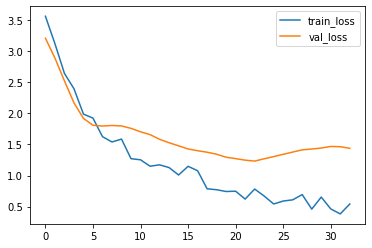

In [37]:
_ = log.plot()

After termination, the `EarlyStopping` callback loads the best performing model (in terms of validation loss).
We can verify this by comparing the minimum validation loss to the validation score of the trained `model`.

In [38]:
log.to_pandas().val_loss.min()

1.2329273223876953

In [39]:
model.score_in_batches(val)

{'loss': 1.2329273223876953}

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

In [40]:
surv = model.predict_surv_df(x_test)

In [41]:
surv

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0.0,9.226423e-01,8.994970e-01,0.911595,0.981758,0.948987,9.339142e-01,0.928296,0.916130,0.947819,0.962289,...,0.896032,9.528024e-01,0.955882,0.922938,0.968257,0.864526,0.943009,0.883051,0.895540,0.948499
20.0,1.466297e-02,6.662333e-02,0.887934,0.913815,0.715588,3.769148e-01,0.917287,0.899229,0.929678,0.667899,...,0.873801,1.366615e-01,0.945063,0.906287,0.947941,0.833542,0.926705,0.875993,0.884827,0.892701
40.0,4.909736e-05,1.383409e-03,0.869157,0.685744,0.214617,4.083005e-02,0.912346,0.880942,0.909119,0.266362,...,0.855179,6.211154e-03,0.938908,0.894177,0.927106,0.808523,0.912120,0.873533,0.880210,0.820135
60.0,1.667530e-07,1.277299e-05,0.848864,0.567076,0.052797,3.337987e-03,0.908985,0.859323,0.889781,0.097926,...,0.841037,1.871191e-04,0.936579,0.885093,0.909964,0.731184,0.903119,0.868232,0.877648,0.510131
80.0,2.405971e-09,6.405916e-07,0.795673,0.389624,0.015410,5.579249e-04,0.870494,0.783123,0.817078,0.056028,...,0.731150,1.914775e-05,0.881080,0.796312,0.871166,0.646817,0.812084,0.854222,0.837113,0.432153
100.0,3.224071e-11,1.708545e-08,0.768344,0.313088,0.005976,9.551225e-05,0.855223,0.737636,0.781446,0.029383,...,0.692858,1.260655e-06,0.863097,0.762195,0.848733,0.549614,0.777813,0.838564,0.823648,0.312603
120.0,3.721036e-13,2.615739e-10,0.757504,0.212434,0.003414,2.833152e-05,0.850786,0.700577,0.763977,0.019049,...,0.683281,1.726105e-07,0.858011,0.753249,0.836695,0.521797,0.767617,0.823139,0.819918,0.006435
140.0,1.889606e-14,4.075956e-12,0.738074,0.080199,0.001601,7.017781e-06,0.838229,0.629081,0.702783,0.015570,...,0.646371,5.633134e-08,0.842014,0.719267,0.822078,0.318166,0.731607,0.805802,0.804902,0.002155
160.0,9.326823e-16,3.619141e-13,0.718559,0.037610,0.000581,1.503587e-06,0.833448,0.527726,0.666014,0.008244,...,0.626837,7.834684e-09,0.834475,0.702726,0.796310,0.291104,0.708905,0.790190,0.801647,0.000142
180.0,3.127612e-16,1.360005e-13,0.398462,0.015158,0.000237,6.278875e-07,0.458497,0.300333,0.322921,0.003633,...,0.372336,2.463685e-09,0.513932,0.387510,0.373037,0.138201,0.386138,0.412112,0.457794,0.000056


We can plot the survival estimates for the first 5 individuals.
Note that the time scale is correct because we have set `model.duration_index` to be the grid points.
We have, however, only defined the survival estimates at the 10 times in our discretization grid, so, the survival estimates is a step function

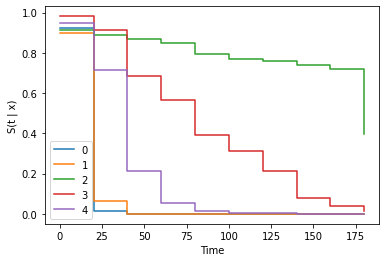

In [42]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

It is, therefore, often beneficial to [interpolate the survival estimates](https://arxiv.org/abs/1910.06724).
Linear interpolation (constant density interpolation) can be performed with the `interpolate` method. We also need to choose how many points we want to replace each grid point with. Her we will use 10.

In [43]:
surv = model.interpolate(10).predict_surv_df(x_test)

In [44]:
surv.shape

(91, 91)

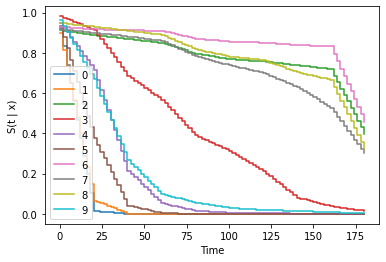

In [45]:
surv.iloc[:, :10].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Evaluation

The `EvalSurv` class contains some useful evaluation criteria for time-to-event prediction.
We set `censor_surv = 'km'` to state that we want to use Kaplan-Meier for estimating the censoring distribution.


In [47]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

#### Concordance

We start with the event-time concordance by [Antolini et al. 2005](https://onlinelibrary.wiley.com/doi/10.1002/sim.2427).

In [48]:
ev.concordance_td('antolini')

0.7990690457719162

#### Brier Score

We can plot the the [IPCW Brier score](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5) for a given set of times.
Here we just use 100 time-points between the min and max duration in the test set.
Note that the score becomes unstable for the highest times. It is therefore common to disregard the rightmost part of the graph.

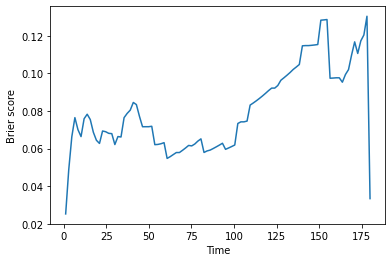

In [49]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

#### Negative binomial log-likelihood

In a similar manner, we can plot the the [IPCW negative binomial log-likelihood](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5).

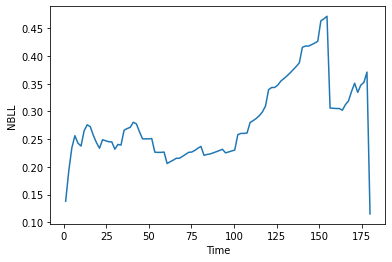

In [50]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

#### Integrated scores

The two time-dependent scores above can be integrated over time to produce a single score [Graf et al. 1999](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5). In practice this is done by numerical integration over a defined `time_grid`.

In [89]:
ev.integrated_brier_score(time_grid) 

0.0997278428459877

In [90]:
ev.integrated_nbll(time_grid) 

0.32793070181987255